In [1]:
import torch
import torchvision
from torchvision import transforms
from editor import editor18
import matplotlib.pyplot as plt
from pretext import GrayScalePL, SuperResolutionPL, RandomPatchPL, RealImagePL
from pretext import RandomPretextConverter
import numpy as np

In [2]:
model = editor18(3)
model_path = './../model/CENC/STL-10/exp2/E_epoch_180'
model.load_state_dict(torch.load(model_path))
model.eval()

Editor(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
            (activate): 

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    #transforms.Normalize([0.447, 0.440, 0.407], [0.260, 0.256, 0.271])
])

# load test data
data_dir = './../data/supervised/test'
test_dataset = torchvision.datasets.ImageFolder(data_dir, transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=2)

In [4]:
# testing some sample
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (96,96)
    plt.show()


dataiter = iter(testloader)
images, labels = dataiter.next()


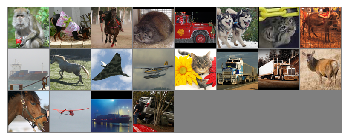

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


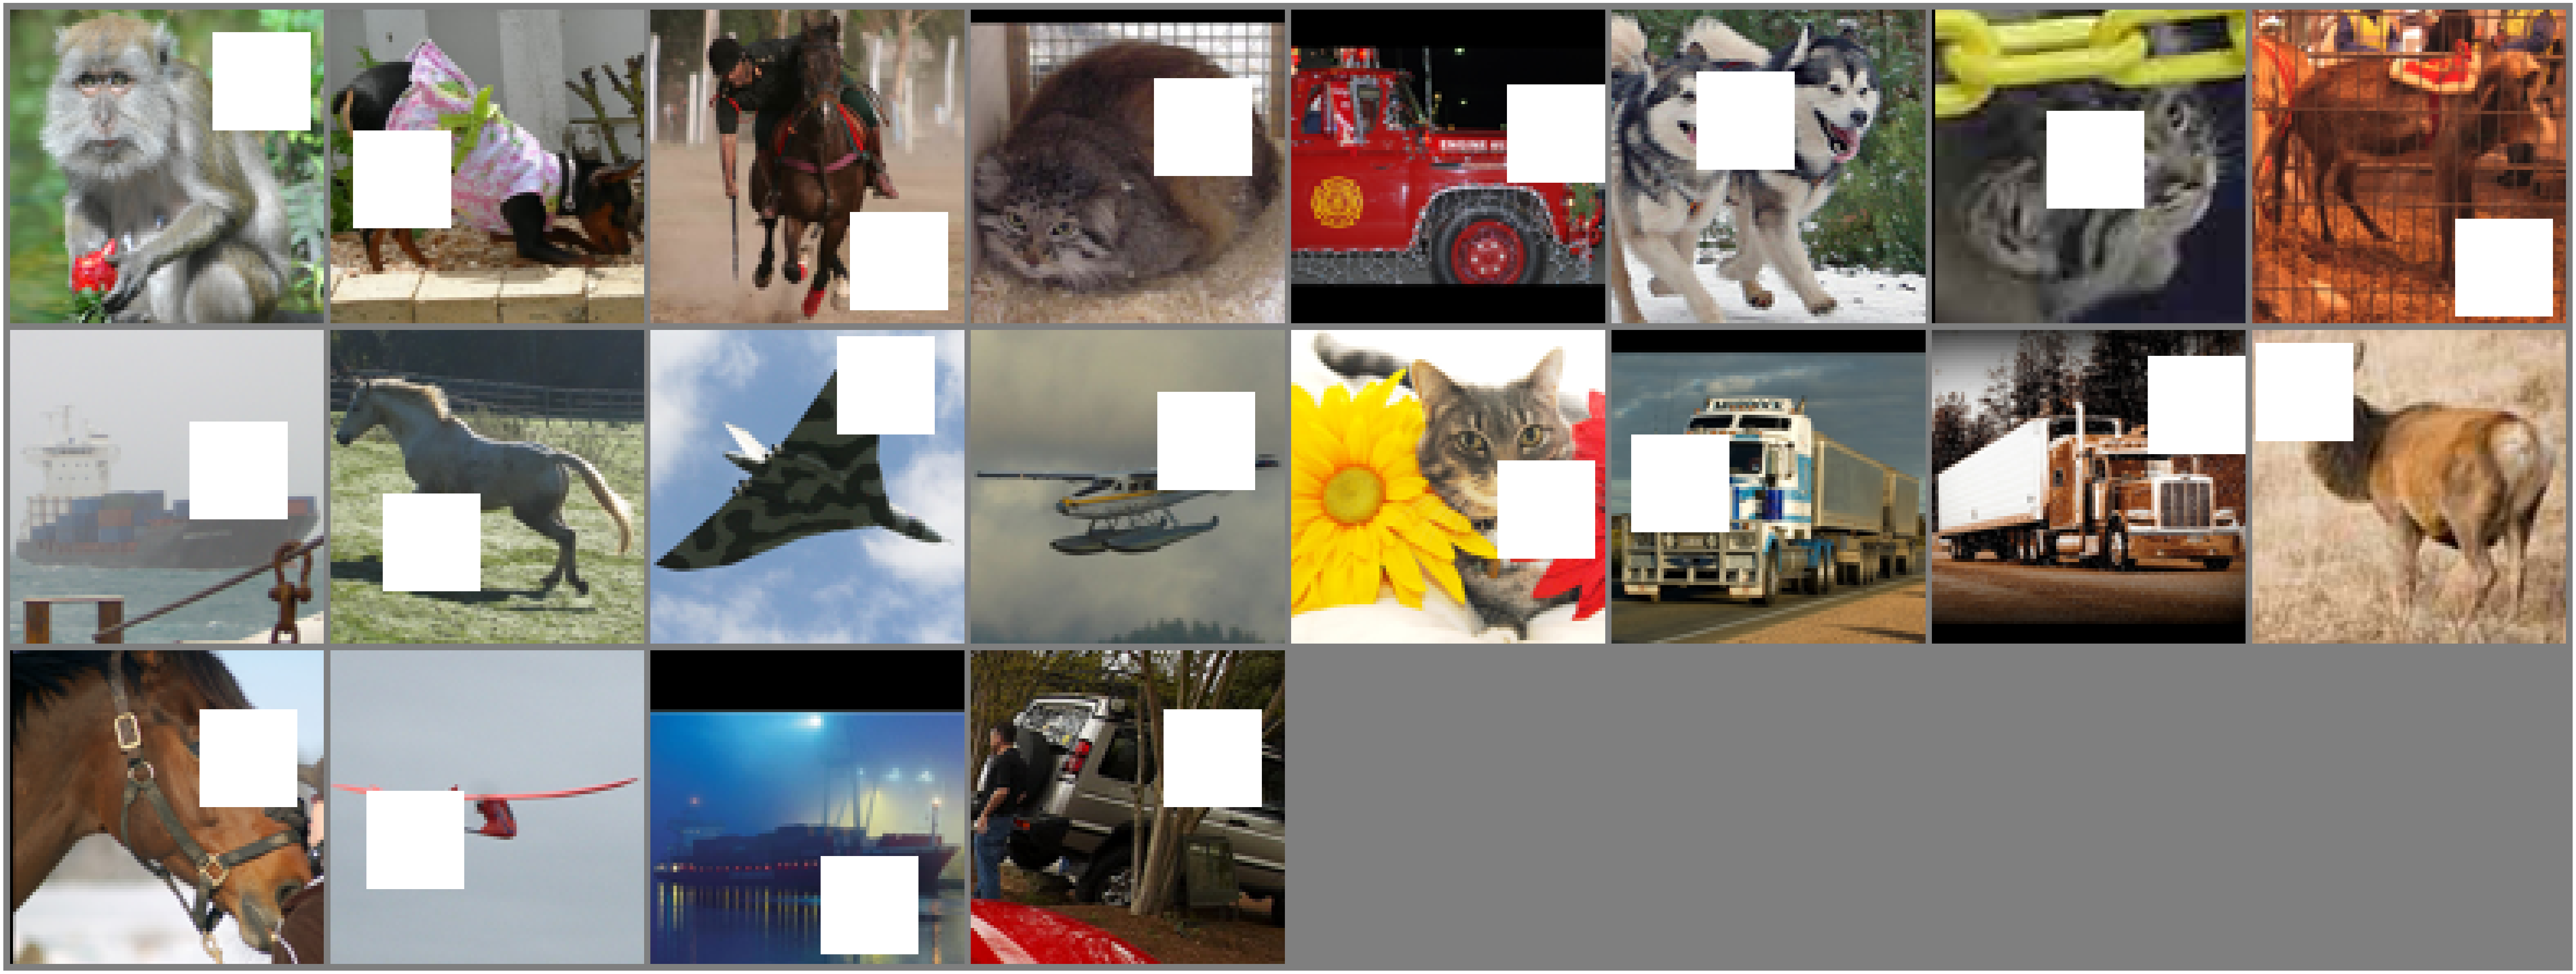

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


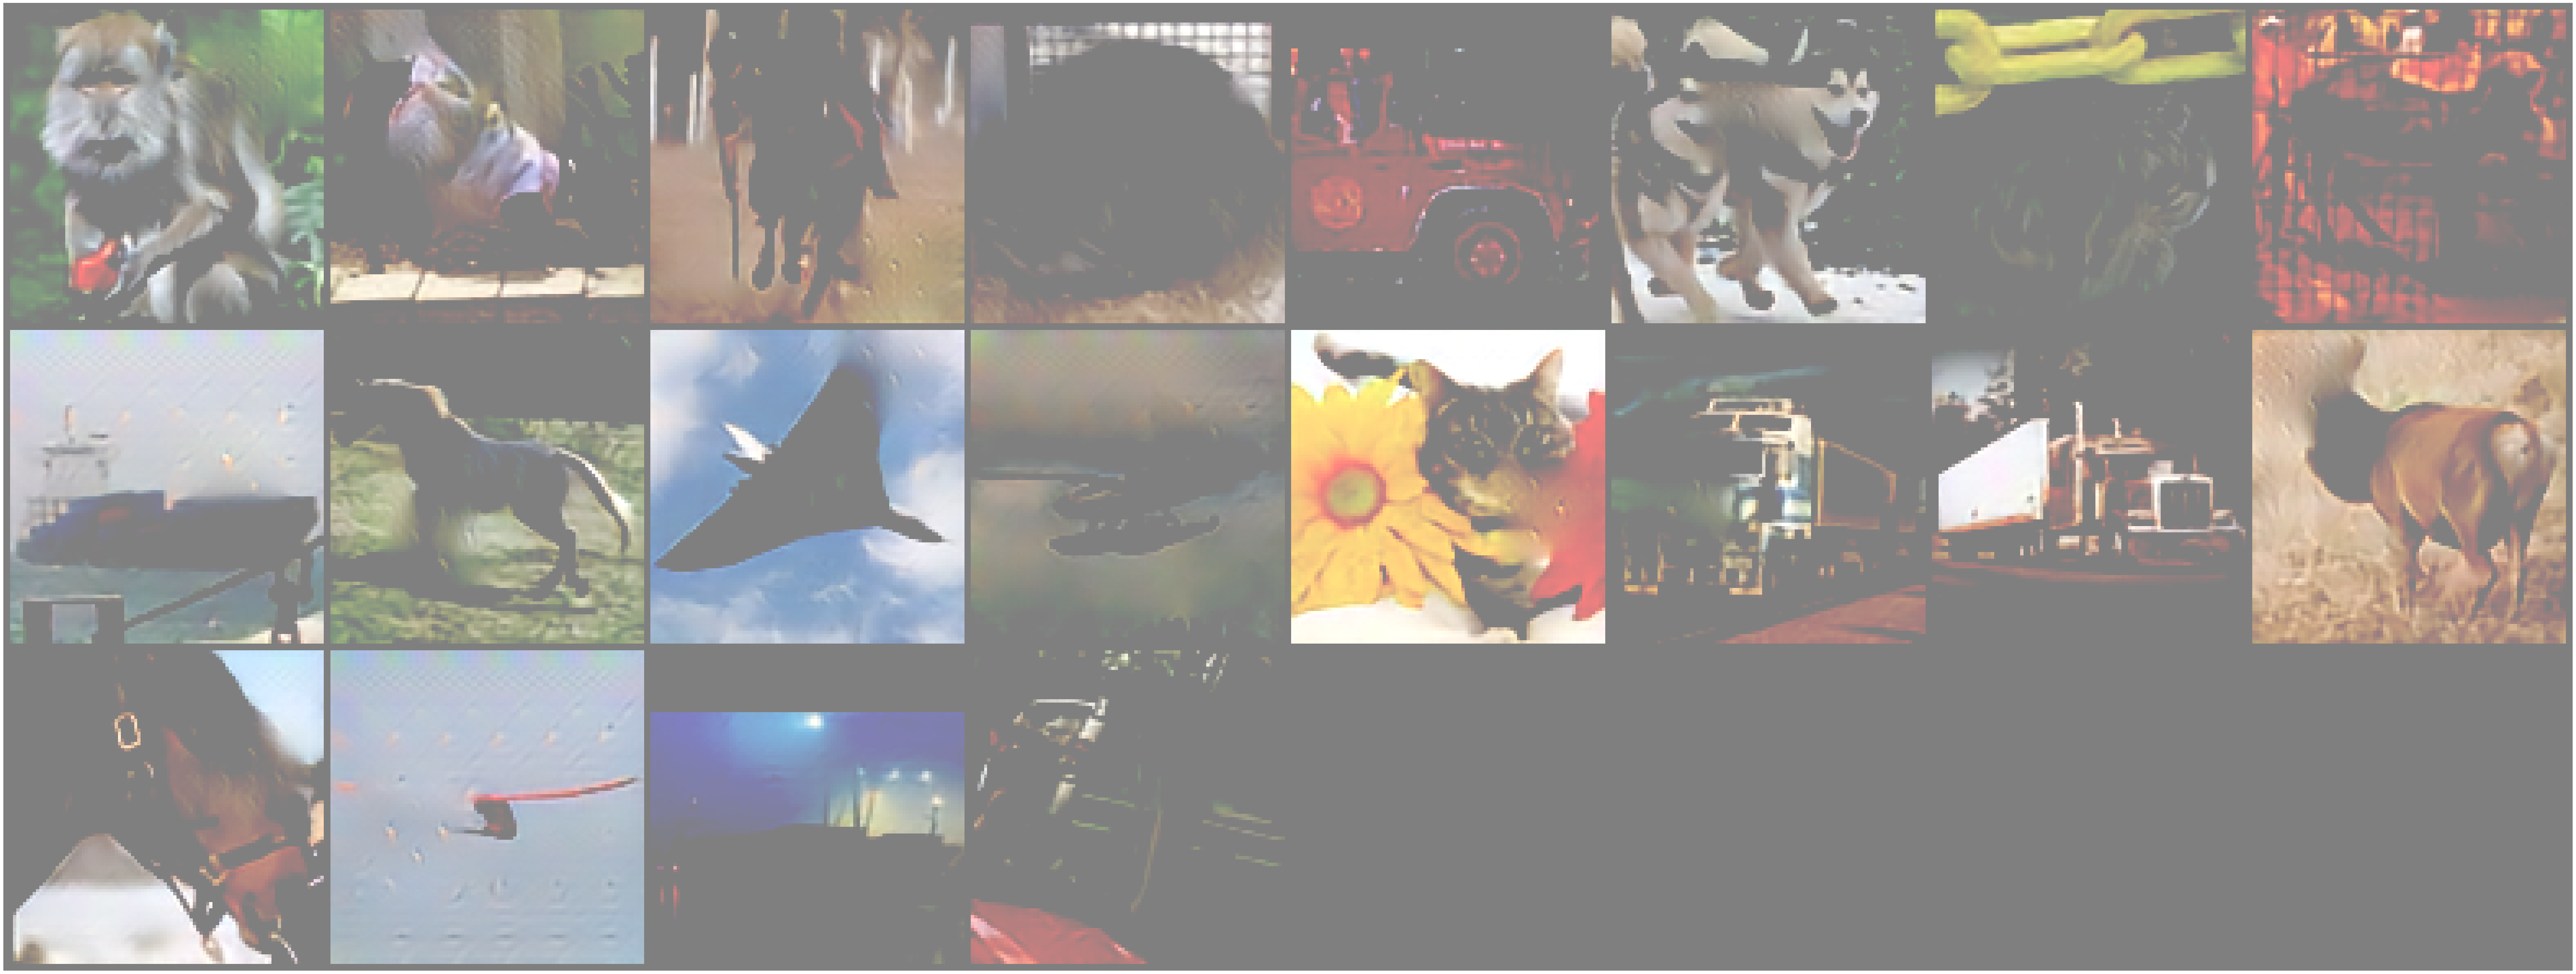

In [5]:
tasks = [
    #RealImagePL,
    #GrayScalePL,
    #SuperResolutionPL,
    RandomPatchPL
]
input_data = RandomPretextConverter(images, tasks)
output = model(input_data).detach()
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(input_data))
imshow(torchvision.utils.make_grid(output))